In [4]:
%matplotlib inline

In [5]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib.image as img

Using TensorFlow backend.


Initialize dataset and random seed (for reproducible results)

In [6]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

# make immutable: we want to keep this data.
X_train_raw.flags.writeable = False
X_test_raw.flags.writeable = False
y_train_raw.flags.writeable = False
y_test_raw.flags.writeable = False

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

We print some samples of the input data just to show what it looks like.

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


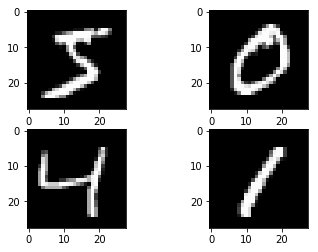

y_train_raw[0]: 5
y_train_raw[1]: 0
y_train_raw[2]: 4
y_train_raw[3]: 1


In [7]:
print("X_train shape:", X_train_raw.shape)
print("y_train shape:", y_train_raw.shape)
print("X_test shape:", X_test_raw.shape)
print("y_test shape:", y_test_raw.shape)

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train_raw[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_raw[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_raw[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_raw[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

for i in range(0,4):
    print("y_train_raw[%d]:" % i, y_train_raw[i])

X_train_flattened shape: (60000, 784)
X_test_flattened shape: (10000, 784)


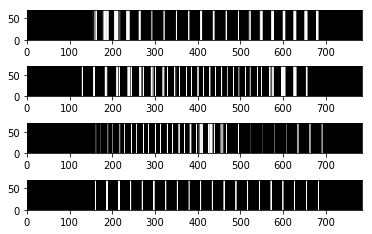

y_train_raw[0]: 5
y_train_raw[1]: 0
y_train_raw[2]: 4
y_train_raw[3]: 1


In [8]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train_raw.shape[1] * X_train_raw.shape[2]
X_train_flattened = X_train_raw.reshape(X_train_raw.shape[0], num_pixels).astype('float32')
X_test_flattened = X_test_raw.reshape(X_test_raw.shape[0], num_pixels).astype('float32')

print("X_train_flattened shape:", X_train_flattened.shape)
print("X_test_flattened shape:", X_test_flattened.shape)
plt.subplot(411)
plt.imshow([X_train_flattened[0]], cmap=plt.get_cmap('gray'), extent = (0, 784, 0, 70), aspect='equal')
plt.subplot(412)
plt.imshow([X_train_flattened[1]], cmap=plt.get_cmap('gray'), extent = (0, 784, 0, 70), aspect='equal')
plt.subplot(413)
plt.imshow([X_train_flattened[2]], cmap=plt.get_cmap('gray'), extent = (0, 784, 0, 70), aspect='equal')
plt.subplot(414)
plt.imshow([X_train_flattened[3]], cmap=plt.get_cmap('gray'), extent = (0, 784, 0, 70), aspect='equal')
plt.show()

for i in range(0,4):
    print("y_train_raw[%d]:" % i, y_train_raw[i])

In [9]:
# normalize inputs from 0-255 to 0-1
X_train = X_train_flattened / 255
X_test = X_test_flattened / 255
print("X_train shape: still", X_train.shape)
print("X_test shape: still", X_test.shape)

X_train shape: still (60000, 784)
X_test shape: still (10000, 784)


In [10]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train_raw)
y_test = np_utils.to_categorical(y_test_raw)
num_classes = y_test.shape[1]
print("y_test_raw[0]: ", y_test_raw[0])
print("y_test[0]: ", y_test[0])

y_test_raw[0]:  7
y_test[0]:  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [11]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
def print_weights(layer):
    weights = layer.get_weights()
    input_weights = weights[0]
    bias_vector = weights[1]
    print("input weights shape:", numpy.array(input_weights).shape)
    print("bias vector shape:", numpy.array(bias_vector).shape)
    print("input weights first neuron:", input_weights[0])
    print("bias vector:", bias_vector)

    
def visualize_model(model):
    for layer in model.layers:
        print("units:", layer.units)
        print("input:", layer.input)
        print("output:", layer.output)
        print_weights(layer)

In [13]:
# build the model
model = baseline_model()
#visualize_model(model)

In [14]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
#visualize_model(model)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 8s - loss: 0.2782 - acc: 0.9210 - val_loss: 0.1412 - val_acc: 0.9573
Epoch 2/10
 - 7s - loss: 0.1116 - acc: 0.9676 - val_loss: 0.0924 - val_acc: 0.9703
Epoch 3/10
 - 7s - loss: 0.0719 - acc: 0.9795 - val_loss: 0.0786 - val_acc: 0.9770
Epoch 4/10
 - 7s - loss: 0.0505 - acc: 0.9854 - val_loss: 0.0741 - val_acc: 0.9768
Epoch 5/10
 - 7s - loss: 0.0375 - acc: 0.9892 - val_loss: 0.0669 - val_acc: 0.9790
Epoch 6/10
 - 7s - loss: 0.0271 - acc: 0.9926 - val_loss: 0.0619 - val_acc: 0.9810
Epoch 7/10
 - 7s - loss: 0.0208 - acc: 0.9949 - val_loss: 0.0620 - val_acc: 0.9804
Epoch 8/10
 - 7s - loss: 0.0140 - acc: 0.9971 - val_loss: 0.0617 - val_acc: 0.9807
Epoch 9/10
 - 7s - loss: 0.0110 - acc: 0.9977 - val_loss: 0.0598 - val_acc: 0.9813
Epoch 10/10
 - 7s - loss: 0.0085 - acc: 0.9985 - val_loss: 0.0610 - val_acc: 0.9814
Baseline Error: 1.86%


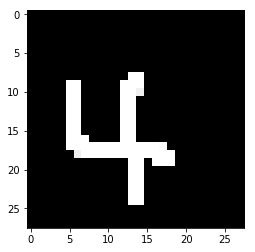

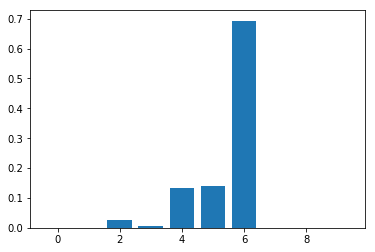

Most likely: 6


In [15]:
fromfile = img.imread("../drawingboard/digit.png")
reduced = fromfile[:,:,0]
plt.imshow(reduced, cmap=plt.get_cmap('gray'))
plt.show()
test = reduced.reshape(784)
predicted = model.predict(numpy.array([test]), 1)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], predicted[0], align='center')
plt.show()
print("Most likely:", numpy.argmax(predicted))

In [16]:
def read_digit(sequence_number):
    fromfile = img.imread("../sevens/digit" + str(sequence_number) + ".png")
    reduced = fromfile[:,:,0]
    #plt.imshow(reduced, cmap=plt.get_cmap('gray'))
    #plt.show()
    return reduced.reshape(784)

In [18]:
five_sevens = [ read_digit(1), read_digit(2), read_digit(3), read_digit(4), read_digit(5)]
x_sevens = numpy.array([five_sevens[i % 5] for i in range(1000)])

seven_encoded = numpy.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0]).transpose()    
y_sevens = numpy.array([seven_encoded for x in range(1000)])

new_x = numpy.append(X_train, x_sevens, axis=0)
new_y = numpy.append(y_train, y_sevens_bitmask, axis=0)

new_model = baseline_model()
new_model.fit(new_x, new_y, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

scores = new_model.evaluate(X_test, y_test, verbose=0)
print("Error: %.2f%%" % (100-scores[1]*100))

Train on 61000 samples, validate on 10000 samples
Epoch 1/10
 - 7s - loss: 0.2729 - acc: 0.9227 - val_loss: 0.1317 - val_acc: 0.9621
Epoch 2/10
 - 7s - loss: 0.1080 - acc: 0.9689 - val_loss: 0.0951 - val_acc: 0.9704
Epoch 3/10
 - 7s - loss: 0.0699 - acc: 0.9801 - val_loss: 0.0793 - val_acc: 0.9764
Epoch 4/10
 - 7s - loss: 0.0491 - acc: 0.9858 - val_loss: 0.0669 - val_acc: 0.9789
Epoch 5/10
 - 10s - loss: 0.0356 - acc: 0.9899 - val_loss: 0.0658 - val_acc: 0.9798
Epoch 6/10
 - 10s - loss: 0.0249 - acc: 0.9932 - val_loss: 0.0649 - val_acc: 0.9797
Epoch 7/10
 - 7s - loss: 0.0188 - acc: 0.9954 - val_loss: 0.0622 - val_acc: 0.9807
Epoch 8/10
 - 8s - loss: 0.0155 - acc: 0.9961 - val_loss: 0.0660 - val_acc: 0.9802
Epoch 9/10
 - 8s - loss: 0.0103 - acc: 0.9979 - val_loss: 0.0601 - val_acc: 0.9814
Epoch 10/10
 - 8s - loss: 0.0081 - acc: 0.9986 - val_loss: 0.0636 - val_acc: 0.9806
Baseline Error: 1.94%
